In [1]:
# setup code, auto reload your .py file
%load_ext autoreload
%autoreload 2

In [2]:
#schedule and timesteps
from dm.diffusion.process import linear_beta_schedule
from dm.diffusion.process import Pre

timesteps = 300
betas =linear_beta_schedule(timesteps=timesteps)
schedule = Pre(betas=betas)

q_sample = schedule.q_sample
sample = schedule.sample

d:\Anaconda3\envs\daily\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#加载数据和数据处理
import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np

image_size = 32
channels = 3
batch_size = 128

transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    torchvision.transforms.RandomHorizontalFlip(),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1)
])

mnist_train = torchvision.datasets.CIFAR10(
root="./data", train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.CIFAR10(
root="./data", train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
next(iter(trainloader))

[tensor([[[[-0.0118, -0.3020, -0.1137,  ...,  0.7725,  0.7569,  0.4980],
           [-0.4353, -0.6863, -0.3176,  ...,  0.5765,  0.7333,  0.6549],
           [-0.3647, -0.5137, -0.4431,  ...,  0.1137,  0.4039,  0.6549],
           ...,
           [-0.6314, -0.5765, -0.4980,  ...,  0.3725,  0.4353,  0.4588],
           [-0.4745, -0.2471, -0.1529,  ...,  0.5686,  0.4902,  0.4980],
           [-0.5294, -0.5451, -0.5451,  ...,  0.4588,  0.6000,  0.6078]],
 
          [[-0.1608, -0.3569, -0.1294,  ...,  0.7020,  0.7255,  0.4745],
           [-0.5451, -0.6941, -0.3020,  ...,  0.5373,  0.7098,  0.6078],
           [-0.4745, -0.5686, -0.4431,  ...,  0.0824,  0.3804,  0.5843],
           ...,
           [-0.6392, -0.5922, -0.5137,  ...,  0.3804,  0.4353,  0.4588],
           [-0.4667, -0.2549, -0.1608,  ...,  0.5608,  0.4824,  0.4902],
           [-0.5451, -0.5294, -0.5451,  ...,  0.4431,  0.6000,  0.6000]],
 
          [[-0.3569, -0.3961, -0.0667,  ...,  0.6000,  0.6235,  0.3255],
           [-

In [5]:
#定义model,optimization,loss_fn
from dm.modules.nn import Unet
from torch.optim import Adam
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
path = './model/ddpm_cifar32.pth'

model = Unet(dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
model.load_state_dict(torch.load(path, map_location=device))
model.eval()
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

def p_losses(model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [6]:
#training
epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(trainloader):
        optimizer.zero_grad()

        #random x0
        batch_size = batch[0].shape[0]
        batch = batch[0].to(device)
        
        #random t
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        #random noise
        loss = p_losses(model, batch, t, loss_type="huber")

        if step % 100 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

Loss: 0.03862740844488144


KeyboardInterrupt: 

In [ ]:
samples = sample(model, image_size=image_size, batch_size=16, channels=channels)

sampling loop time step: 100%|██████████| 300/300 [00:06<00:00, 45.36it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


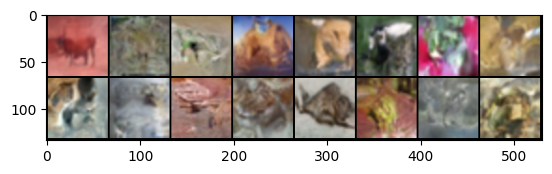

In [ ]:
#reverse photo process
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Resize(64)
     #Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     #Lambda(lambda t: t * 255.),
     #Lambda(lambda t: t.numpy().astype(np.uint8)),
     #ToTensor()
])

import matplotlib.pyplot as plt
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

images = torch.tensor(samples[-1])
images = [reverse_transform(img) for img in images]

imgshow(torchvision.utils.make_grid(images))

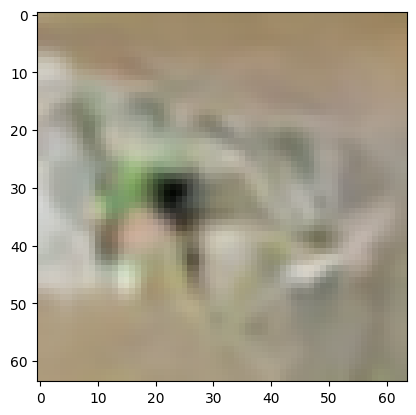

In [ ]:
# show a random one
random_index = 2
plt.imshow(np.transpose(images[random_index],(1,2,0)))